In [10]:
import numpy as np
from numpy import linalg as LA
from scipy.optimize import root
from wolframclient.evaluation import WolframLanguageSession
from wolframclient.language import wl, wlexpr
from itertools import combinations
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as colors
import csv
import pandas as pd
from scipy.stats import norm

# define matplotlib style
mpl.style.use("classic")
mpl.rc("xtick", labelsize=15)
mpl.rc("ytick", labelsize=15)
mpl.rc("xtick.major", size=14, width=2)
mpl.rc("xtick.minor", size=7, width=2, visible=True)
mpl.rc("ytick.major", size=14, width=2)
mpl.rc("ytick.minor", size=7, width=2, visible=True)
mpl.rc("lines", linewidth=2, markersize=5)
mpl.rc("axes", linewidth=2, labelsize=15, labelpad=2.5)
mpl.rc("legend", fontsize=15, loc="best", frameon=True, numpoints=1)

mpl.rc("font", family="STIXGeneral")
mpl.rc("mathtext", fontset="stix")
mpl.rc("axes", titlesize=20, titlepad=10)

/var/folders/1r/x7pmt5qs61j4zkk17bl3rg0m0000gn/T/ipykernel_3047/2500220939.py:7: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('/Users/yongao/Desktop/8.13/mit-jlab-sp25/tasks/x1/x1.2/long_data/maxborn.txt', delim_whitespace=True, comment='#', header=None)


   0        1         2     3      4      5      6      7          8      9   \
0   1  0:00:09  1/1/2019   209  128.0    8.0   7.38  23.98  102714.59  50546   
1   2  0:00:09  1/1/2019   266  976.0  336.0  63.33  23.98  102714.59   4791   
2   3  0:00:09  1/1/2019   976  115.0    9.0   7.01  23.98  102714.93  52391   
3   4  0:00:11  1/1/2019  2021  830.0   56.0  23.16  23.98  102715.26  52388   
4   5  0:00:11  1/1/2019  2062  698.0   12.0  15.65  23.98  102715.26   1848   

   10  
0   0  
1   0  
2   0  
3   0  
4   0  


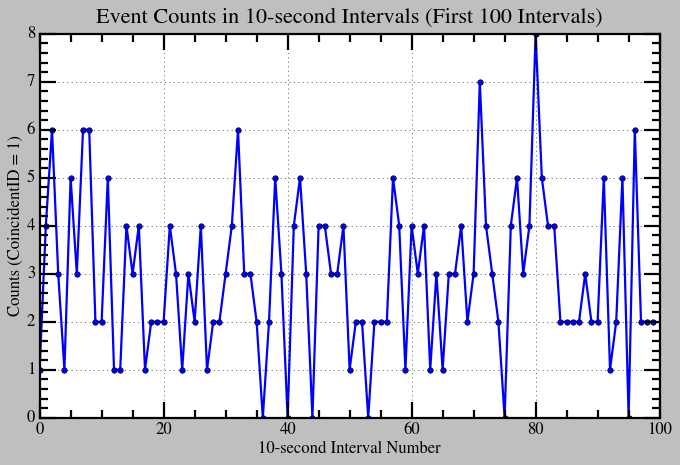

Mean counts per interval: 2.92
Jitter (standard deviation): 1.6494872175340072


In [20]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the data file.
# We assume that header lines starting with '#' should be skipped.
# Adjust the filename ('FileC013.txt') if necessary.
df = pd.read_csv('/Users/yongao/Desktop/8.13/mit-jlab-sp25/tasks/x1/x1.2/long_data/maxborn.txt', delim_whitespace=True, comment='#', header=None)

# Assign column names based on the file documentation:
# Columns: EventNumber, Time, Date, TimeStamp[ms], ADC1, ADC2, SiPM[mV],
# Temp[C], Pressure[Pa], DeadTime[us], CoincidentID, Device
print(df.head())

df.columns = ['EventNumber', 'Time', 'Date', 'TimeStamp_ms', 'ADC1', 'ADC2',
'SiPM_mV', 'Temp_C', 'Pressure_Pa', 'DeadTime_us', 'CoincidentID']

# Convert the 'Time' column (formatted like '0:00:07') to seconds
df['Seconds'] = pd.to_timedelta(df['Time']).dt.total_seconds()

# Create a new column with the 10-second interval index (starting at 0)
df['Interval'] = (df['Seconds'] // 10).astype(int)

# Filter the rows to include only events with CoincidentID == 1
df_coinc = df[df['CoincidentID'] == 1]

# Count events per interval for intervals 0 through 99 (first 100 intervals)
# Group by the 'Interval' column
counts = df_coinc[df_coinc['Interval'] < 100].groupby('Interval').size()
# counts = df_coinc[(df_coinc['Interval'] >= 200) & (df_coinc['Interval'] < 300)].groupby('Interval').size()

# To ensure we have a count for every interval 0-99 (even if zero events occurred),
# we reindex and fill missing intervals with 0.
all_intervals = pd.Series(0, index=range(100))
# all_intervals = pd.Series(0, index=range(200, 300))
counts = all_intervals.add(counts, fill_value=0)

# Plot the counts versus the interval number
plt.figure(figsize=(10, 6))
plt.plot(counts.index, counts.values, marker='o', linestyle='-')
plt.xlabel('10-second Interval Number')
plt.ylabel('Counts (CoincidentID = 1)')
plt.title('Event Counts in 10-second Intervals (First 100 Intervals)')
plt.grid(True)
# plt.savefig('counts_vs_interval.png', dpi=300, bbox_inches='tight')
plt.show()

# Compute the jitter as the standard deviation of counts
jitter = counts.std()
mean_counts = counts.mean()
print('Mean counts per interval:', mean_counts)
print('Jitter (standard deviation):', jitter)

# For example, if the events follow Poisson statistics, one might expect
# jitter ~ sqrt(mean_counts). Compare the printed jitter with that value.

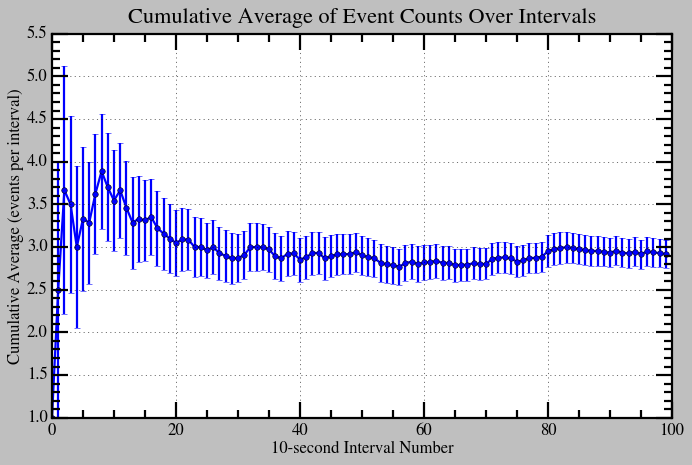

In [21]:
n_intervals = np.arange(1, len(counts)+1)
running_avg = counts.cumsum() / (counts.index + 1)
running_std = counts.expanding().std(ddof=1)
running_error = running_std / np.sqrt(n_intervals)
plt.figure(figsize=(10, 6))
plt.errorbar(running_avg.index, running_avg.values, yerr=running_error.values, fmt='o-', capsize=3)
plt.xlabel('10-second Interval Number')
plt.ylabel('Cumulative Average (events per interval)')
plt.title('Cumulative Average of Event Counts Over Intervals')
plt.grid(True)
# plt.savefig('cumulative_avg.png', dpi=300, bbox_inches='tight')
plt.show()

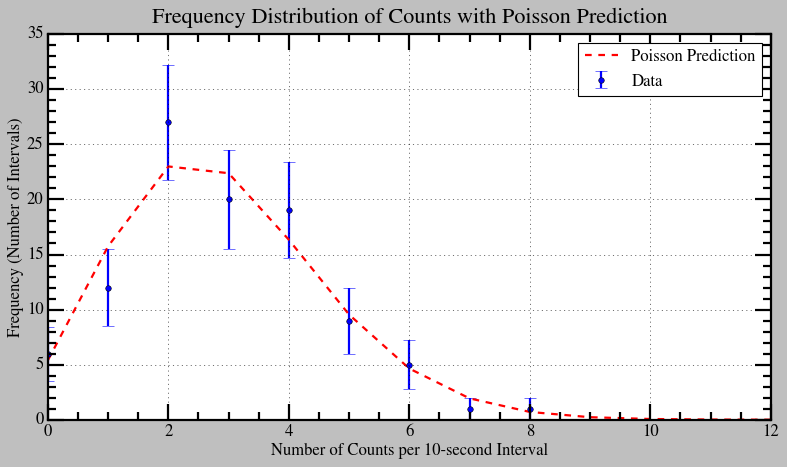

Chi^2: 3.297050244364093


In [30]:
from scipy.stats import poisson

# ----------------------------------------------
# Frequency Distribution of Counts
# ----------------------------------------------
# Calculate the frequency distribution:
# For each unique count value, determine how many intervals had that count.
count_freq = counts.value_counts().sort_index()  # index: count value, value: number of intervals

# Prepare data for plotting:
x = count_freq.index         # Number of counts per interval (k)
y = count_freq.values        # Frequency: number of intervals with that many counts
error = np.sqrt(y)           # Poisson error bars for the frequency (sqrt(frequency))

plt.figure(figsize=(10, 6))
plt.errorbar(x, y, yerr=error, fmt='o', capsize=5, label='Data')

# ----------------------------------------------
# Poisson Prediction and Overlay
# ----------------------------------------------
# Use the mean count (lambda) to compute the Poisson prediction.
lambda_val = mean_counts

# Define a range of count bins. We take the maximum of:
#   (a) the maximum count observed, and 
#   (b) lambda + 5*sqrt(lambda) (to cover the tail of the distribution).
max_bin = max(x.max(), int(np.ceil(lambda_val + 5 * np.sqrt(lambda_val))))
k_range = np.arange(0, max_bin + 1)

# Compute the predicted frequency for each count bin (renormalized to 100 intervals).
predicted = 100 * poisson.pmf(k_range, mu=lambda_val)

# Overlay the Poisson prediction on the plot.
plt.plot(k_range, predicted, 'r--', label='Poisson Prediction')
plt.xlabel('Number of Counts per 10-second Interval')
plt.ylabel('Frequency (Number of Intervals)')
plt.title('Frequency Distribution of Counts with Poisson Prediction')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig('frequency_distribution.png', dpi=300)
plt.show()

# ----------------------------------------------
# Calculate Chi^2 between Data and Poisson Prediction
# ----------------------------------------------
# Build an array of observed frequencies for bins in k_range.
observed = np.array([count_freq.get(k, 0) for k in k_range])

# To avoid division by zero, only include bins where the predicted value is > 0.
valid = predicted > 0

# Compute Pearson's chi-square:
chi2 = np.sum((observed[valid] - predicted[valid])**2 / predicted[valid])
print("Chi^2:", chi2)

/var/folders/1r/x7pmt5qs61j4zkk17bl3rg0m0000gn/T/ipykernel_3047/3733129431.py:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(


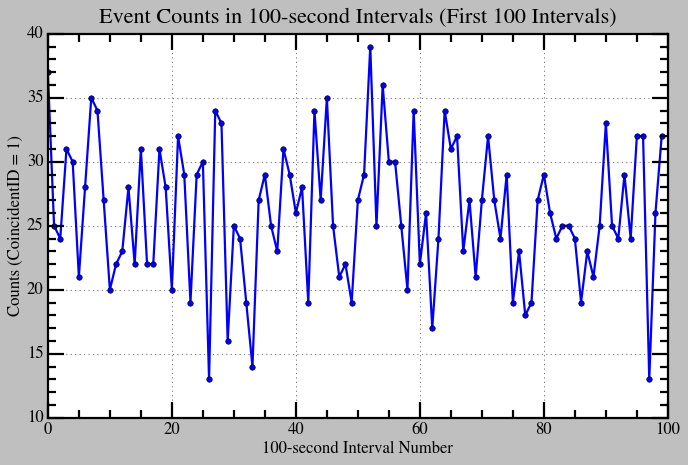

Mean counts per interval: 26.06
Jitter (standard deviation): 5.441739175348746


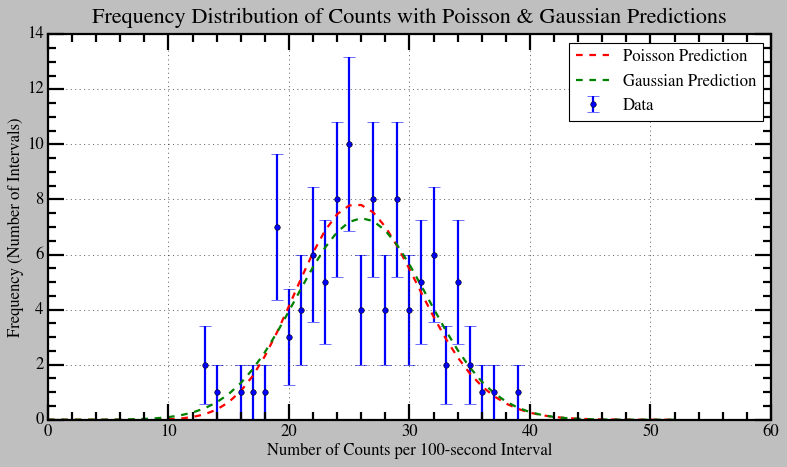

Chi^2 for Poisson prediction: 37.02225287351112
Chi^2 for Gaussian prediction: 25.503634491386364


In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import poisson, norm

# ---------------------------
# Read and Process the Data
# ---------------------------
df = pd.read_csv(
    '/Users/yongao/Desktop/8.13/mit-jlab-sp25/tasks/x1/x1.2/long_data/maxborn.txt',
    delim_whitespace=True, comment='#', header=None
)

# Assign column names.
df.columns = ['EventNumber', 'Time', 'Date', 'TimeStamp_ms', 'ADC1', 'ADC2',
              'SiPM_mV', 'Temp_C', 'Pressure_Pa', 'DeadTime_us', 'CoincidentID']

# Convert the 'Time' column (e.g., '0:00:07') to seconds.
df['Seconds'] = pd.to_timedelta(df['Time']).dt.total_seconds()

# Create a new column with the 100-second interval index.
df['Interval'] = (df['Seconds'] // 100).astype(int)

# Filter for events with CoincidentID == 1.
df_coinc = df[df['CoincidentID'] == 1]

# Count events per interval for intervals 0 through 99 (first 100 intervals).
counts = df_coinc[df_coinc['Interval'] < 100].groupby('Interval').size()

# Ensure every interval 0-99 is represented (fill missing intervals with 0).
all_intervals = pd.Series(0, index=range(100))
counts = all_intervals.add(counts, fill_value=0)

# ----------------------------------------------
# Plot counts vs interval number (optional)
# ----------------------------------------------
plt.figure(figsize=(10, 6))
plt.plot(counts.index, counts.values, marker='o', linestyle='-')
plt.xlabel('100-second Interval Number')
plt.ylabel('Counts (CoincidentID = 1)')
plt.title('Event Counts in 100-second Intervals (First 100 Intervals)')
plt.grid(True)
plt.show()

# Compute the mean (lambda) and standard deviation (jitter) per interval.
mean_counts = counts.mean()
jitter = counts.std()
print('Mean counts per interval:', mean_counts)
print('Jitter (standard deviation):', jitter)

# ----------------------------------------------
# Frequency Distribution of Counts
# ----------------------------------------------
# Calculate frequency distribution: for each count value, 
# determine how many intervals had that many counts.
count_freq = counts.value_counts().sort_index()

# Prepare data for plotting:
# x: count value (k), y: number of intervals with that count.
x = count_freq.index           # unique count values
y = count_freq.values          # frequencies (number of intervals)
error = np.sqrt(y)             # Poisson error bars for the frequency

# ----------------------------------------------
# Define Count Bins and Compute Predictions
# ----------------------------------------------
# Define a range of count bins.
# Use the maximum of:
#   (a) the maximum count observed, and 
#   (b) lambda + 5*sqrt(lambda) (to cover the tail).
max_bin = max(x.max(), int(np.ceil(mean_counts + 5 * np.sqrt(mean_counts))))
k_range = np.arange(0, max_bin + 1)

# Poisson Prediction: probability mass * 100 intervals.
poisson_pred = 100 * poisson.pmf(k_range, mu=mean_counts)

# Gaussian Prediction:
# For each integer bin k, compute the probability by integrating the normal PDF
# from k-0.5 to k+0.5.
gauss_pred = 100 * (norm.cdf(k_range + 0.5, loc=mean_counts, scale=jitter) -
                    norm.cdf(k_range - 0.5, loc=mean_counts, scale=jitter))

# ----------------------------------------------
# Plot Frequency Distribution with Both Predictions
# ----------------------------------------------
plt.figure(figsize=(10, 6))
plt.errorbar(x, y, yerr=error, fmt='o', capsize=5, label='Data')

plt.plot(k_range, poisson_pred, 'r--', lw=2, label='Poisson Prediction')
plt.plot(k_range, gauss_pred, 'g--', lw=2, label='Gaussian Prediction')

plt.xlabel('Number of Counts per 100-second Interval')
plt.ylabel('Frequency (Number of Intervals)')
plt.title('Frequency Distribution of Counts with Poisson & Gaussian Predictions')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig('frequency_distribution_predictions.png', dpi=300)
plt.show()

# ----------------------------------------------
# Calculate Chi^2 for Poisson and Gaussian Predictions
# ----------------------------------------------
# Build an array of observed frequencies for bins in k_range.
observed = np.array([count_freq.get(k, 0) for k in k_range])

# For Poisson chi^2: consider bins with predicted > 0.
valid_poisson = poisson_pred > 0
chi2_poisson = np.sum((observed[valid_poisson] - poisson_pred[valid_poisson])**2 /
                      poisson_pred[valid_poisson])

# For Gaussian chi^2: consider bins with predicted > 0.
valid_gauss = gauss_pred > 0
chi2_gauss = np.sum((observed[valid_gauss] - gauss_pred[valid_gauss])**2 /
                    gauss_pred[valid_gauss])

print("Chi^2 for Poisson prediction:", chi2_poisson)
print("Chi^2 for Gaussian prediction:", chi2_gauss)